In [278]:
"""Solve
u_t + (u^2 / 2)_x = 0 on [-1, 6]
with fixed boundary conditions.
"""
import numpy as np
import matplotlib.pyplot as plt

In [280]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 250
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

T = 2
tsteps = 366
    hx = 0.0546875
    ht = 0.00546448
lambda = 0.1


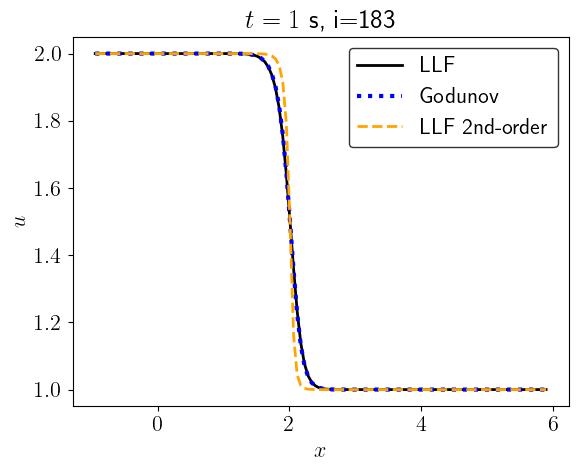

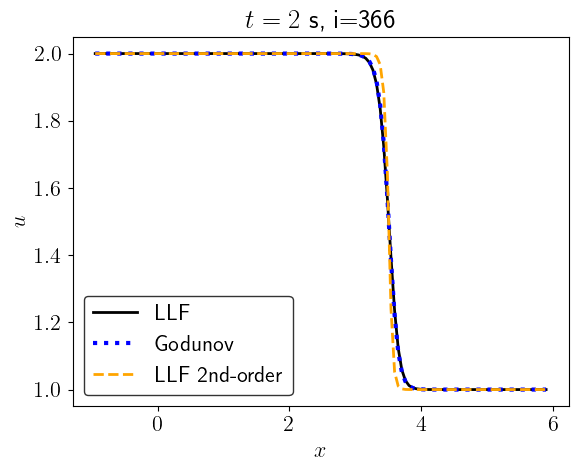

In [294]:
def IC(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if (x[j] < 0):
            u[j] = 2
        elif (x[j] >= 0) and (x[j] <= 1):
            u[j] = 2-x[j]
        else:
            u[j] = 1
    return u

def exact():
    # IMPLEMENT
    # ....
    return 0

T = 2.0
gamma = 0.1
nx = 128


x, hx = np.linspace(-1,6, nx, endpoint=False, retstep=True)
# Ghost cell mask: pretend first and last DoF is a ghost cell
mask =  np.ones(len(x), dtype=bool) 
mask[:1] = mask[-1:] = False
# Indexing arrays
K = np.arange(0, nx)   # 0, ..., nx-1
Km1 = np.roll(K, 1)    # nx-1, 0, 1, ..., nx-2
Kp1 = np.roll(K, -1)   # 1, ..., nx


ht = hx * gamma
nt = int(np.ceil(T/ht))
ht = T/nt

print('T = %g' % T)
print('tsteps = %d' % nt)
print('    hx = %g' % hx)
print('    ht = %g' % ht)
print('lambda = %g' % gamma)

u0 = IC(x)
u_LLF = u0.copy()
u_G = u0.copy()
u_LLF_2 = u0.copy()

def f(u):
    return u**2/2

def fprime(u):
    return u

def flux_LLF(um, up):
    alpha = np.max(np.abs(np.array([fprime(um), fprime(up)])), axis=0)
    return (f(um) + f(up))/2 - alpha/2 * (up - um)
    
def flux_G(um, up):
    # Solve a Riemann problem at every interface k+1/2
    flux_arr = np.zeros_like(um)

    shock = um > up
    shock_speed = np.zeros_like(um)
    shock_speed[shock] = (f(up[shock]) - f(um[shock])) / (up[shock] - um[shock])

    case1 = np.logical_and(shock, shock_speed > 0)
    flux_arr[case1] = f(um[case1])

    case2 = np.logical_and(shock, shock_speed <= 0)
    flux_arr[case2] = f(up[case2])

    case3 = np.logical_and(~shock, fprime(um) >= 0)
    flux_arr[case3] = f(um[case3])

    case4 = np.logical_and(~shock, fprime(up) <= 0)
    flux_arr[case4] = f(up[case4])

    case5 = np.logical_and.reduce([~shock, fprime(um) <= 0, fprime(up) >= 0])
    flux_arr[case5] = 0
    
    # Non-Pythonic/non-optimized code below, but works
    # for i, (um, up) in enumerate(zip(u[K], u[Kp1])):
        # if um > up: # shock
        #     s = (f(up)-f(um))/(up - um) # compute shock speed
        #     if s > 0:
        #         flux_arr[i] = f(um)
        #     else:
        #         flux_arr[i] =  f(up)
        # else: # rarefaction
        #     if fprime(um) >= 0:
        #         flux_arr[i] =  f(um)
        #     elif fprime(up) <= 0:
        #         flux_arr[i] =  f(up)
        #     else:
        #         flux_arr[i] =  0
    return flux_arr

def delta(u, omega):
    u_K = u
    u_Km1 = np.roll(u,1)
    u_Kp1 = np.roll(u,-1)
    return 0.5*(1+omega)*(u_K-u_Km1) + 0.5*(1-omega)*(u_Kp1-u_K)
    
def lin_reconstr(u, omega=-1):
    # Compute the slopes in every cell:
    d = delta(u,omega)
    
    u_K = u
    d_K = d
    u_Kp1 = np.roll(u,-1)
    d_Kp1 = np.roll(d,-1)
    u_Km1 = np.roll(u,1)
    eps = 1e-12
    
    r = (u_K - u_Km1)/(u_Kp1 - u + eps)
    phi_K = np.max(np.vstack([np.min(np.vstack([r, np.ones_like(r)]), axis=0) , np.zeros_like(r)]),axis=0)
    phi_Kp1 = np.roll(phi_K, -1)
    
    um = u_K + 0.5*phi_K*d_K
    up = u_Kp1 - 0.5*phi_Kp1*d_Kp1

    if len(um) == 1:
        um = um.item()
    if len(up) == 1:
        up = up.item()
    return um, up
    

for n in range(1, nt+1):
    #########################################################################################
    # Local Lax-Friedrichs w/ constant reconstruction + Euler-explicit time integration
    f_LLF = flux_LLF(u_LLF[K],u_LLF[Kp1])
    dudt_LLF = (f_LLF[K] - f_LLF[Km1])/hx
    u_LLF[mask] = (u_LLF - ht*dudt_LLF)[mask]
    #########################################################################################
    # Godunov w/ constant reconstruction + Euler-explicit time integration
    f_G = flux_G(u_G[K], u_G[Kp1])
    dudt_G = (f_G[K]-f_G[Km1])/hx
    u_G[mask] = (u_G - ht*dudt_G)[mask]
    #########################################################################################
    # Local Lax-Friedrichs with linear-reconstruction + two-stage RK time integration
    u_LLF_2_half = u_LLF_2.copy()

    # Stage 1:
    um_LLF_2, up_LLF_2 = lin_reconstr(u_LLF_2)

    # Fix the k=1/2 and k=n-1/2 fluxes based on the boundary conditions:
    temp, _ = lin_reconstr(np.array([u0[0], u_LLF_2[1]]))
    um_LLF_2[0], up_LLF_2[0] = temp
    temp, _ = lin_reconstr(np.array([u_LLF_2[-2], u0[-1]]))
    um_LLF_2[-1], up_LLF_2[-2] = temp

    f_LLF_2 = flux_LLF(um_LLF_2, up_LLF_2)

    z_LLF_2 = (f_LLF_2[K] - f_LLF_2[Km1])/hx
    u_LLF_2_half[mask] = (u_LLF_2 - (ht/2)*z_LLF_2)[mask]

    # Stage 2:
    um_LLF_2, up_LLF_2 = lin_reconstr(u_LLF_2_half)

    temp, _ = lin_reconstr(np.array([u0[0], u_LLF_2_half[1]]))
    um_LLF_2[0], up_LLF_2[0] = temp
    temp, _ = lin_reconstr(np.array([u_LLF_2_half[-2], u0[-1]]))
    um_LLF_2[-1], up_LLF_2[-2] = temp

    f_LLF_2_half = flux_LLF(um_LLF_2, up_LLF_2)

    z_LLF_2_half = (f_LLF_2_half[K] - f_LLF_2_half[Km1])/hx
    u_LLF_2[mask] = (u_LLF_2 - ht*z_LLF_2_half)[mask]
    #########################################################################################

    
    # uexact = exact_rarefraction(x, time, u0)

    # Plot Computed and exact solution 
    time = n * ht
    #if n % 50 == 0:
    if abs(time-1.) < ht/2 or abs(time-2) < ht/2.: 
        plt.title('$t=%g$ s, i=%g' % (n * ht, n))
        plt.plot(x[mask], u_LLF[mask], 'k-', linewidth=2, label='LLF')
        plt.plot(x[mask], u_G[mask], 'b:', linewidth=3, label='Godunov')
        plt.plot(x[mask], u_LLF_2[mask], color="orange", linestyle='--', linewidth=2, label='LLF 2nd-order')
        #plt.plot(x[mask], uexact[mask], '-.', linewidth=3, label='exact')
        plt.xlabel("$x$")
        plt.ylabel("$u$")
        plt.legend()
        plt.show()
